<a href="https://colab.research.google.com/github/KobOlek/QR-coder/blob/main/Flowers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

In [30]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = .2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = .2,
    subset="validation",
    seed=123,
    image_size = (img_width, img_height),
    batch_size=batch_size
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [40]:
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width)),
    layers.experimental.preprocessing.RandomRotation(.1),
    layers.experimental.preprocessing.RandomZoom(.1),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(.2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [41]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                  

In [42]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 170s 2s/step - loss: 1.2945 - accuracy: 0.4455 - val_loss: 1.1135 - val_accuracy: 0.5388
Epoch 2/10
92/92 [==============================] - 168s 2s/step - loss: 1.0258 - accuracy: 0.5920 - val_loss: 0.9224 - val_accuracy: 0.6454
Epoch 3/10
92/92 [==============================] - 169s 2s/step - loss: 0.8872 - accuracy: 0.6580 - val_loss: 0.7673 - val_accuracy: 0.7149
Epoch 4/10
92/92 [==============================] - 166s 2s/step - loss: 0.8265 - accuracy: 0.6846 - val_loss: 0.7310 - val_accuracy: 0.7323
Epoch 5/10
92/92 [==============================] - 166s 2s/step - loss: 0.7628 - accuracy: 0.7180 - val_loss: 0.8385 - val_accuracy: 0.6761
Epoch 6/10
92/92 [==============================] - 168s 2s/step - loss: 0.7304 - accuracy: 0.7183 - val_loss: 0.6840 - val_accuracy: 0.7289
Epoch 7/10
92/92 [==============================] - 164s 2s/step - loss: 0.6956 - accuracy: 0.7343 - val_loss: 0.6913 - val_accuracy: 0.7333
Epoch 8/10
92

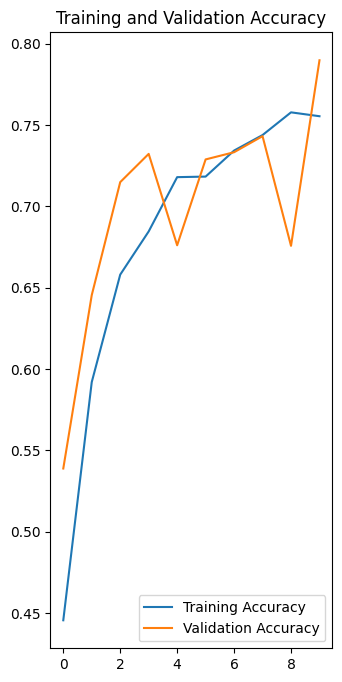

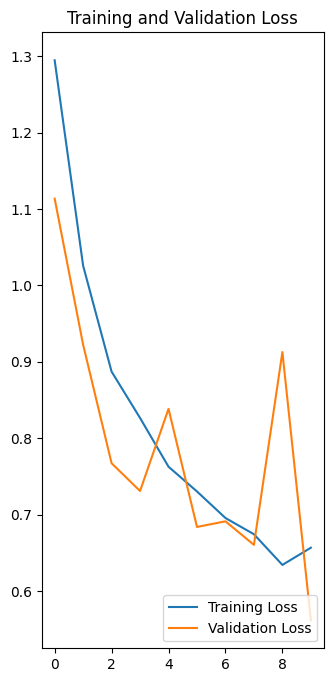

In [43]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

In [46]:
model.save_weigths("my_flowers_model")

AttributeError: ignored

In [47]:
model.evaluate(train_ds, verbose=2)

92/92 - 33s - loss: 0.5619 - accuracy: 0.7899 - 33s/epoch - 357ms/step


[0.5618523359298706, 0.789850115776062]

Saving OIP (1).jpg to OIP (1) (1).jpg
1/1 [==============================] - 0s 36ms/step
На зображенні daisy (78.60% ймовірність)


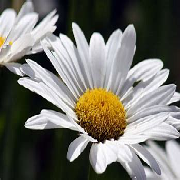

In [60]:
from google.colab import files
img = files.upload()

img = list(img)[0]

img = tf.keras.utils.load_img(
    img, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На зображенні {} ({:.2f}% ймовірність)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()